# Imports

In [1]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 10.1 MB/s 


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.7.0


# Dataset Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir /content/dataset

In [5]:
!unzip '/content/drive/MyDrive/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (8).jp

# Hyperparameters Setup

In [6]:
IMAGE_SIZE = 224
PATCH_SIZE = 6
BATCH_SIZE = 32
NUM_CLASSES = 2
INPUT_CLASSES = (32, 32, 3)
EPOCHS = 20
LEARNING_RATE = 1e-4

# Model Setup

In [7]:
DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

# images generator
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                           validation_split = 0.2)

# load training and validating images from directory
train_set = data_gen.flow_from_directory(DF_TRAIN,
                                         subset = 'training',
                                         seed = 1,
                                         color_mode = 'rgb',
                                         shuffle = True,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary')

valid_set = data_gen.flow_from_directory(DF_TRAIN,
                                         subset = 'validation',
                                         seed = 1,
                                         color_mode = 'rgb',
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary')


test_set  = data_gen.flow_from_directory(DF_TEST,
                                         seed = 1,
                                         color_mode = 'rgb',
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary')


Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


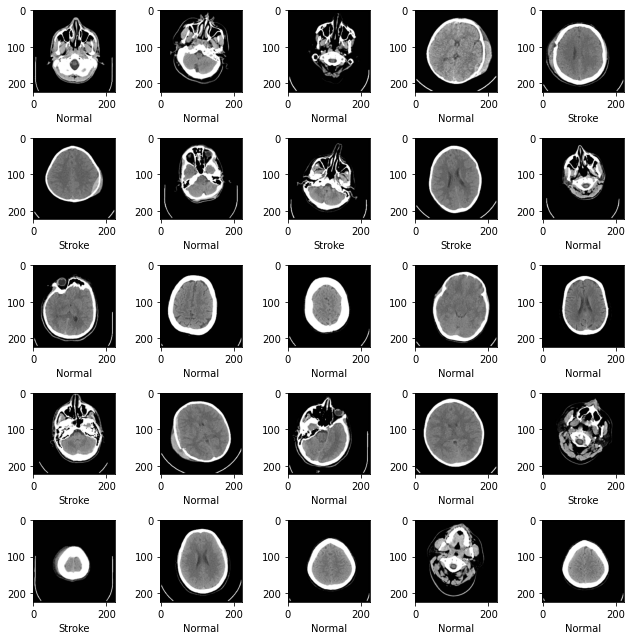

In [8]:
images, labels = next(train_set)[:25]
fig, axes = plt.subplots(5, 5, figsize=(9, 9))
for img, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(img)
    ax.set_xlabel(list(train_set.class_indices)[label.astype(int)])
plt.tight_layout()
plt.show()

# Build ViT Model

In [9]:
!pip install -U vit-keras

**Build ViT B16 model**

In [10]:
from vit_keras import vit

# build vit model with 16 patch_size
vit_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = True,
        pretrained_top = True,
        classes = NUM_CLASSES)

347512832/347502902 [==============================] - 7s 0us/step


**Visualizing Attention Maps**



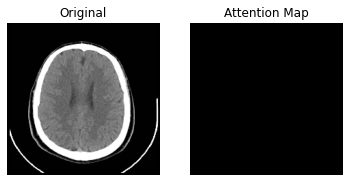

In [11]:
from vit_keras import visualize

images, labels = next(train_set)[:10]
image = images[0]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

**Model fine-tunning**

In [12]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(NUM_CLASSES, 'softmax')
    ],
    name = 'vit_model')

model.summary()

Model: "vit_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 1000)              86567656  
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                11011     
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)                 24

# Model training

In [13]:
STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_set,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_set,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          # callbacks = callbacks
          )



Epoch 1/20
56/56 [==============================] - 83s 911ms/step - loss: 0.8018 - accuracy: 0.5455 - val_loss: 0.6922 - val_accuracy: 0.6183
Epoch 2/20
56/56 [==============================] - 47s 846ms/step - loss: 0.6067 - accuracy: 0.6710 - val_loss: 0.6887 - val_accuracy: 0.6429
Epoch 3/20
56/56 [==============================] - 48s 855ms/step - loss: 0.4821 - accuracy: 0.7656 - val_loss: 0.6848 - val_accuracy: 0.6362
Epoch 4/20
56/56 [==============================] - 47s 846ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.6741 - val_accuracy: 0.6942
Epoch 5/20
56/56 [==============================] - 47s 845ms/step - loss: 0.1740 - accuracy: 0.9480 - val_loss: 0.6378 - val_accuracy: 0.7455
Epoch 6/20
56/56 [==============================] - 47s 845ms/step - loss: 0.1360 - accuracy: 0.9536 - val_loss: 0.6164 - val_accuracy: 0.7143
Epoch 7/20
56/56 [==============================] - 47s 846ms/step - loss: 0.0847 - accuracy: 0.9746 - val_loss: 0.5473 - val_accuracy: 0.7433

In [14]:
model.save_weights('model.h5')

# Results

[[0.9974201  0.00257995]
 [0.9975083  0.00249174]
 [0.997088   0.00291198]
 [0.99623376 0.00376622]
 [0.99599385 0.00400612]
 [0.9957818  0.00421818]
 [0.99602616 0.00397386]
 [0.99560344 0.00439656]
 [0.9966073  0.00339271]
 [0.9971673  0.00283269]
 [0.9979532  0.00204684]
 [0.9967801  0.00321991]
 [0.9983317  0.00166828]
 [0.9982529  0.001747  ]
 [0.9981797  0.00182039]
 [0.9981154  0.00188459]
 [0.99829    0.00171004]
 [0.99812835 0.00187166]
 [0.9983006  0.00169941]
 [0.99833506 0.00166495]
 [0.99819773 0.00180226]
 [0.99858886 0.00141108]
 [0.9971413  0.00285861]
 [0.9949568  0.00504323]
 [0.9949497  0.00505032]
 [0.9933907  0.00660934]
 [0.9896227  0.0103773 ]
 [0.9965366  0.00346335]
 [0.99597305 0.00402693]
 [0.9980373  0.0019627 ]
 [0.9965789  0.00342112]
 [0.99417925 0.0058208 ]
 [0.9980354  0.00196458]
 [0.9978757  0.00212427]
 [0.9979463  0.00205363]
 [0.9978782  0.0021218 ]
 [0.99800044 0.00199957]
 [0.99847704 0.00152299]
 [0.9880685  0.01193145]
 [0.9869828  0.01301718]


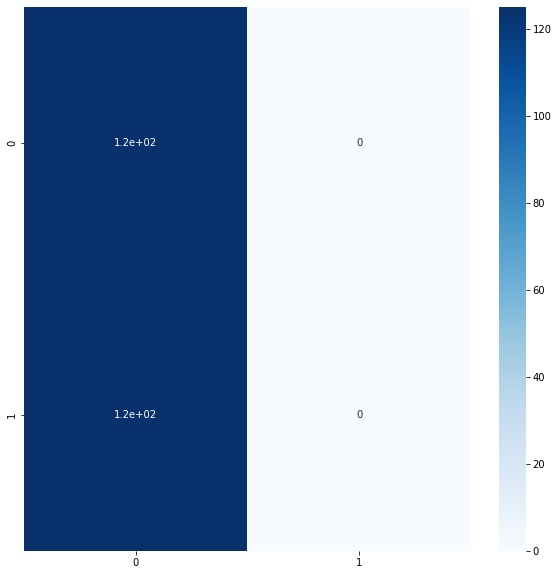

In [19]:
Y_pred = model.predict(test_set, steps = test_set.n // test_set.batch_size + 1)
# print(Y_pred)
predicted_classes = np.argmax(Y_pred, axis = 1)
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))